<a href="https://colab.research.google.com/github/miladlink/Beginner_Deep_Learning/blob/main/Cifar10_Torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torchvision.utils import make_grid

In [ ]:
#from google.colab import drive
drive.mount('/content/drive')

In [ ]:
dataset = CIFAR10 (root = '/data', download = True, transform = transforms.ToTensor())


Extracting /data/cifar-10-python.tar.gz to /data


In [ ]:
tfms = transforms.Compose ([transforms.ToTensor (), transforms.Normalize ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
train_ds = CIFAR10 (root = '/data', train = True, transform = tfms)
test_ds = CIFAR10 (root = '/data', train = False, transform = tfms)

In [ ]:
train_ds

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [ ]:
len (test_ds)

10000

In [ ]:
train_ds.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
train_ds.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [ ]:
img, label = train_ds [0]
print (img.shape)
print (label)

torch.Size([3, 32, 32])
6


In [ ]:
train_ds.data.shape

(50000, 32, 32, 3)

In [ ]:
len (train_ds.targets)

50000

frog


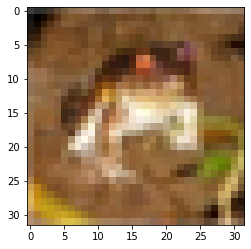

In [ ]:
plt.imshow (train_ds.data [0])
print (train_ds.classes [train_ds.targets [0]])

In [ ]:
def split_indices (n, val_pct = 0.2, seed = 99):
   n_val = int (n * val_pct)
   np.random.seed (seed)
   idx = np.random.permutation (n)
   return idx [n_val:], idx [:n_val]

In [ ]:
??torchvision.datasets #or dir ()

In [ ]:
train_indices, valid_indices = split_indices (len (train_ds), seed = 42)

In [ ]:
train_sampler = SubsetRandomSampler (train_indices)
valid_sampler = SubsetRandomSampler (valid_indices)

In [ ]:
train_dl = DataLoader (train_ds, batch_size = 100, sampler = train_sampler, num_workers = 2)
valid_dl = DataLoader (train_ds, batch_size = 100, sampler = valid_sampler, num_workers = 2)

In [ ]:
#each iter shows batch of data when call next show another iteration
train_iter = iter(train_dl)
img, label = train_iter.next () # = next (iter (train_dl)) or (img.shape for img, label in train_dl)
img.shape

torch.Size([100, 3, 32, 32])

In [ ]:
def show_batch (dl):
   imgs, labels = next (iter (dl))
   out = make_grid (imgs, 10)
   out = out.numpy ().transpose ((1, 2, 0))
   out = out * 0.5 + 0.5
   out = np.clip (out, 0, 1)
   plt.figure (figsize = (12, 16))
   plt.imshow (out)
   plt.title ('Random Batch of Images')

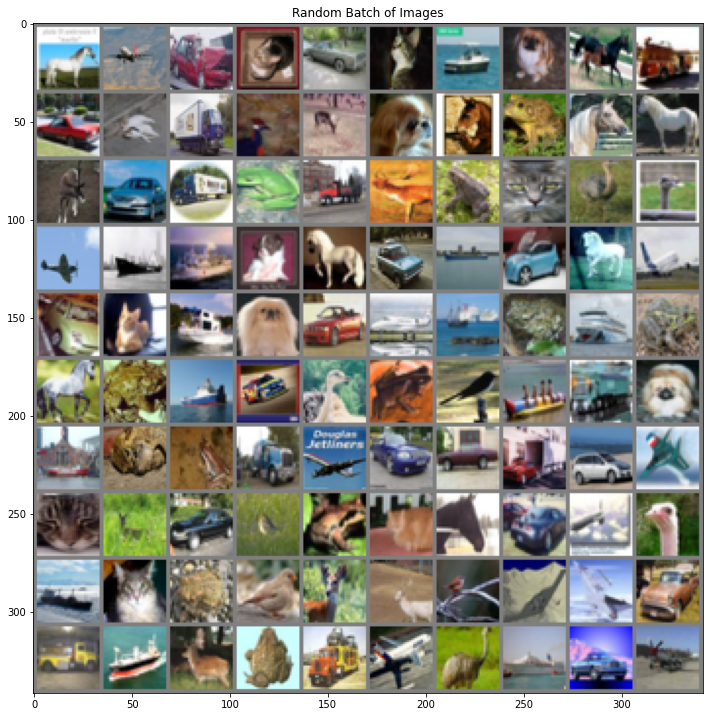

In [ ]:
show_batch (train_dl)

In [ ]:
class Cnn (nn.Module):
   def __init__(self):
      super (Cnn, self).__init__()
      self.conv1 = nn.Sequential (nn.Conv2d (3, 16, 3, stride = 1, padding = 1), nn.ReLU (), nn.MaxPool2d (2))
      self.conv2 = nn.Sequential (nn.Conv2d (16, 16, 3, stride = 1, padding = 1), nn.ReLU (), nn.MaxPool2d (2))
      self.conv3 = nn.Sequential (nn.Conv2d (16, 16, 3, stride = 1, padding = 1), nn.ReLU (), nn.MaxPool2d (2))
      self.conv4 = nn.Sequential (nn.Conv2d (16, 16, 3, stride = 1, padding = 1), nn.ReLU (), nn.MaxPool2d (2))
      self.conv5 = nn.Sequential (nn.Conv2d (16, 16, 3, stride = 1, padding = 1), nn.ReLU (), nn.MaxPool2d (2))
      self.fc1 = nn.Sequential (nn.Linear (16, 10)) #nn.Softmax (dim = 1))
   
   def forward (self, x):
      out = self.conv1 (x)
      out = self.conv2 (out)
      out = self.conv3 (out)
      out = self.conv4 (out)
      out = self.conv5 (out)
      out = out.view (out.size (0), -1)
      out = self.fc1 (out)
 
      return out

In [ ]:
model = Cnn ()

In [ ]:
device = torch.device ('cuda' if torch.cuda.is_available () else 'cpu')

In [ ]:
def to_device (data, device):
   if isinstance (data, (list, tuple)):
      return [to_device (x, device) for x in data]
   return data.to (device, non_blocking = True)

In [ ]:
class DeviceDataLoader ():
   def __init__ (self, dl, device):
      self.dl = dl
      self.device = device
 
   def __iter__ (self):
      for b in self.dl:
         yield to_device (b, self.device)
 
   def __len__ (self):
      return len (self.dl)

In [ ]:
train_dl = DeviceDataLoader (train_dl, device)
valid_dl = DeviceDataLoader (valid_dl, device)
to_device (model, device)

Cnn(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mo

In [ ]:
xb, yb = next (iter (train_dl))
output = model (xb)
output.shape

torch.Size([100, 10])

In [ ]:
total = np.sum (nums)
avg_loss = np.sum (np.multiply (losses, nums)) / total

In [ ]:
 
def accuracy (outputs, labels): # if dim = 0, it gives sum of all batch with a number
   _, preds = torch.max (outputs, dim = 1) # or preds = torch.argmax (outputs, dim = 1)
   return torch.sum (preds == labels).item () / len (preds)

In [ ]:
def batch_loss (model, xb, yb, loss_fn, opt = None, metric_fn = None):
   
   outputs = model (xb)
   loss = loss_fn (outputs, yb)
 
   if opt is not None:
      loss.backward ()
      opt.step ()
      opt.zero_grad ()
 
   metrics = None
   if metric_fn is not None:
      metrics = metric_fn (outputs, yb)
 
   return loss.item (), len (xb), metrics

In [ ]:
def evaluate (model, data_dl, loss_fn, metric_fn = None):
   with torch.no_grad ():
      results = [batch_loss (model, xb, yb, loss_fn, metric_fn = metric_fn) for xb, yb in data_dl]
      losses, nums, metrics = zip (*results)
 
      total = np.sum (nums)
      avg_loss = np.sum (np.multiply (losses, nums)) / total
 
      avg_metrics = None
      if metric_fn is not None:
         avg_metrics = np.sum (np.multiply (metrics, nums)) / total
 
   return avg_loss, total, avg_metrics

In [ ]:
def fit (epochs, model, train_dl, valid_dl, loss_fn, opt = None, metric_fn = None):
   train_losses, losses, accs, val_losses, val_accs = [], [], [], [], []
   
   for epoch in range (epochs):
      model.train ()
      for xb, yb in train_dl: 
         train_loss,_,_ = batch_loss (model, xb, yb, loss_fn, opt)
      
      model.eval ()
      loss,_, acc = evaluate (model, train_dl, loss_fn, metric_fn)
      val_loss,_, val_acc = evaluate (model, valid_dl, loss_fn, metric_fn)
 
      train_losses.append (train_loss)
      losses.append (loss)
      accs.append (acc)
      val_losses.append (val_loss)
      val_accs.append (val_acc)
      
      print ('Epoch: [{}/{}], train loss: {:.4f}, loss: {:.4f}, accuracy: {:.4f}, val loss: {:.4f}, val accuracy: {:.4f}'.format (epoch + 1, epochs, train_loss, loss, acc, val_loss, val_acc))
 
   return train_losses, losses, accs, val_losses, val_accs

In [ ]:
opt = optim.Adam (model.parameters (), lr = 0.005)
loss_fn = nn.CrossEntropyLoss ()

In [ ]:
to_device (loss_fn, device)

CrossEntropyLoss()

In [ ]:
history = fit (10, model, train_dl, valid_dl, loss_fn, opt, accuracy)

Epoch: [1/10], train loss: 0.8128, loss: 0.9834, accuracy: 0.6477, val loss: 1.0660, val accuracy: 0.6166
Epoch: [2/10], train loss: 0.9149, loss: 0.9738, accuracy: 0.6539, val loss: 1.0619, val accuracy: 0.6200
Epoch: [3/10], train loss: 0.9434, loss: 0.9591, accuracy: 0.6610, val loss: 1.0464, val accuracy: 0.6250
Epoch: [4/10], train loss: 0.8660, loss: 0.9494, accuracy: 0.6615, val loss: 1.0385, val accuracy: 0.6309
Epoch: [5/10], train loss: 0.7752, loss: 0.9185, accuracy: 0.6738, val loss: 1.0143, val accuracy: 0.6427
Epoch: [6/10], train loss: 0.9103, loss: 0.9441, accuracy: 0.6619, val loss: 1.0504, val accuracy: 0.6271
Epoch: [7/10], train loss: 0.9237, loss: 0.8756, accuracy: 0.6923, val loss: 0.9868, val accuracy: 0.6481
Epoch: [8/10], train loss: 0.8794, loss: 0.8623, accuracy: 0.6947, val loss: 0.9829, val accuracy: 0.6527
Epoch: [9/10], train loss: 0.8050, loss: 0.9139, accuracy: 0.6771, val loss: 1.0484, val accuracy: 0.6295
Epoch: [10/10], train loss: 0.8020, loss: 0.92

In [ ]:
train_losses = history [0]
accs = history [2]
val_losses = history [3]
val_accs = history [4]

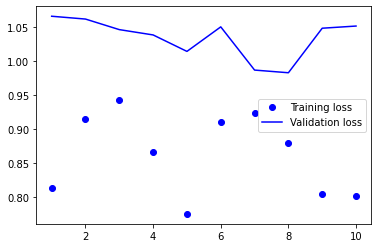

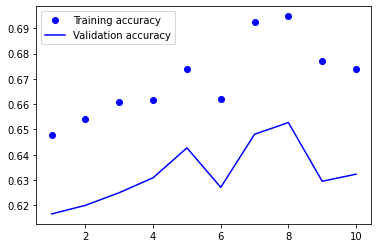

In [ ]:
epochs = range (1, len (accs) + 1)
plt.plot (epochs, train_losses, 'bo', label = 'Training loss')
plt.plot (epochs, val_losses, 'b', label = 'Validation loss')
plt.legend ()
plt.figure ()
plt.plot (epochs, accs, 'bo', label = 'Training accuracy')
plt.plot (epochs, val_accs, 'b', label = 'Validation accuracy')
plt.legend ()
plt.show ()

In [ ]:
path = './cifar10_model.pth'
torch.save (model.state_dict (), path)

In [ ]:
test_dl = DataLoader (test_ds, batch_size = 100, num_workers = 2)
test_dl = DeviceDataLoader (test_dl, device)

In [ ]:
_,_, test_acc = evaluate (model, test_dl, loss_fn, metric_fn = accuracy)
test_acc

0.6325

In [ ]:
def imshow (inp, title = None):
   inp = inp.cpu ().numpy ().transpose ((1, 2, 0))
   inp = inp * 0.5 + 0.5
   inp = np.clip (inp, 0, 1)
   plt.imshow (inp)
   plt.axis ('off')
   if title is not None:
      plt.title (title)

In [ ]:
def predict_image (imgs, labels, n):
   output = model (imgs)
   _, preds = torch.max (output, dim = 1)
 
   imshow (imgs [n])
 
   print ('Acctual Name: {}, Predicted: {}'.format (train_ds.classes [labels [n]], train_ds.classes [preds [n]]))

In [ ]:
 imgs, lbls = next (iter (test_dl))

Acctual Name: frog, Predicted: frog


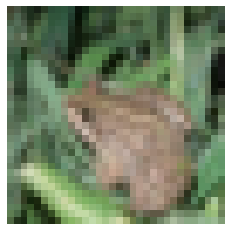

In [ ]:
predict_image (imgs, lbls, 4)